In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.dates as mdates  
from sklearn import linear_model

from keras.models import Sequential 
from keras.layers import Dense  
import keras.backend as K 
from keras.callbacks import EarlyStopping  
from keras.optimizers import Adam 
from keras.models import load_model 
from keras.layers import LSTM  
from keras.utils import plot_model

# Package for additional features
from talib import abstract as ta
from talib import RSI
from talib import MACD

# Fine tuning
from sklearn.model_selection import GridSearchCV





2023-12-23 09:46:30.846139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define the ticker symbol for the company (e.g., Apple Inc. with the symbol AAPL)
ticker_symbol = "AAPL"

start_date = "1990-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

data = yf.download(ticker_symbol, start=start_date, end=end_date)

df = pd.DataFrame(data)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263413,183198400
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.265181,207995200
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.266066,221513600
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266950,123312000
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268718,101572800
...,...,...,...,...,...,...
2023-12-18,196.089996,196.630005,194.389999,195.889999,195.889999,55751900
2023-12-19,196.160004,196.949997,195.889999,196.940002,196.940002,40714100
2023-12-20,196.899994,197.679993,194.830002,194.830002,194.830002,52242800


<Axes: xlabel='Date'>

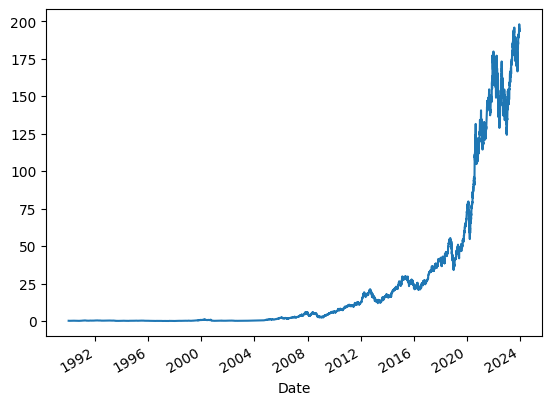

In [3]:
df["Adj Close"].plot()

In [4]:
# Relative Strength Index (RSI): price movement over a given period.
df['RSI'] = RSI(df['Close'], timeperiod=14)

In [5]:
# Moving Average Convergence Divergence (MACD): Identifies trend strength and potential turning points.
macd, signal, hist = MACD(df['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd
df['Signal'] = signal
df['MACD_Hist'] = hist

In [6]:
# Average True Range (ATR): Measures market volatility.
# Higher ATR values indicate higher market volatility, meaning prices are fluctuating more significantly.
# Lower ATR values indicate lower volatility, suggesting a calmer market with smaller price swings.
# You can use ATR to set stop-loss orders, manage risk, and identify potential trading opportunities based on volatility changes.

close_prices = df["Adj Close"]
high_prices = df["High"]
low_prices = df["Low"]

true_range = pd.Series(
    [max(hi - lo, abs(hi - close_prev), abs(lo - close_prev))
     for hi, lo, close_prev in zip(high_prices, low_prices, close_prices.shift(1))]
)

# Higher -> less sensitive to recent data change 
# Lower -> More sensitive to recent data cahange
# 14: Common window size, which can balance. 
window = 14
atr = true_range.rolling(window=window).mean()

atr_df = pd.DataFrame({'ATR': atr.values}, index=df.index)

# Merge the original DataFrame with the new ATR DataFrame
df = pd.merge(df, atr_df, left_index=True, right_index=True)

In [7]:
# Re-order the data frame

new_order = ["Open", "High", "Low", "Volume", "RSI", 'MACD', 'Signal',
       'MACD_Hist', "ATR", "Adj Close"]
df = df[new_order]
df

,Open,High,Low,Volume,RSI,MACD,Signal,MACD_Hist,ATR,Adj Close
Date,,,,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,183198400,NaN,NaN,NaN,NaN,NaN,0.263413
1990-01-03,0.339286,0.339286,0.334821,207995200,NaN,NaN,NaN,NaN,NaN,0.265181
1990-01-04,0.341518,0.345982,0.332589,221513600,NaN,NaN,NaN,NaN,NaN,0.266066
1990-01-05,0.337054,0.341518,0.330357,123312000,NaN,NaN,NaN,NaN,NaN,0.266950
1990-01-08,0.334821,0.339286,0.330357,101572800,NaN,NaN,NaN,NaN,NaN,0.268718
...,...,...,...,...,...,...,...,...,...,...
2023-12-18,196.089996,196.630005,194.389999,55751900,62.613964,3.615939,3.610162,0.005777,3.043571,195.889999
2023-12-19,196.160004,196.949997,195.889999,40714100,64.484296,3.528949,3.593919,-0.064970,2.896429,196.940002
2023-12-20,196.899994,197.679993,194.830002,52242800,58.184935,3.252259,3.525587,-0.273328,2.947856,194.830002


In [8]:
# Drop null values 
df.dropna(inplace=True)


In [9]:
#Set Target Variable
output_var = pd.DataFrame(df["Adj Close"])

#Selecting the Features
features = ["Open", "High", "Low", "Volume", "RSI", 'MACD', 'Signal',
       'MACD_Hist', "ATR"]

In [10]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform = pd.DataFrame(data=feature_transform, columns=features, index=df.index)
feature_transform.head()

,Open,High,Low,Volume,RSI,MACD,Signal,MACD_Hist,ATR
Date,,,,,,,,,
1990-02-16,0.000964,0.000951,0.000952,0.016823,0.368987,0.469252,0.455807,0.512677,0.006598
1990-02-20,0.000931,0.000917,0.000918,0.016288,0.350255,0.469255,0.455837,0.512606,0.006490
1990-02-21,0.000897,0.000940,0.000896,0.023387,0.400539,0.469280,0.455867,0.512601,0.006473
1990-02-22,0.000953,0.000951,0.000918,0.025985,0.325560,0.469261,0.455886,0.512496,0.006454
1990-02-23,0.000897,0.000906,0.000907,0.019889,0.351060,0.469259,0.455902,0.512451,0.006380


In [11]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [12]:
# Convert the data for LSTM
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

/Users/ryandi/anaconda3/envs/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


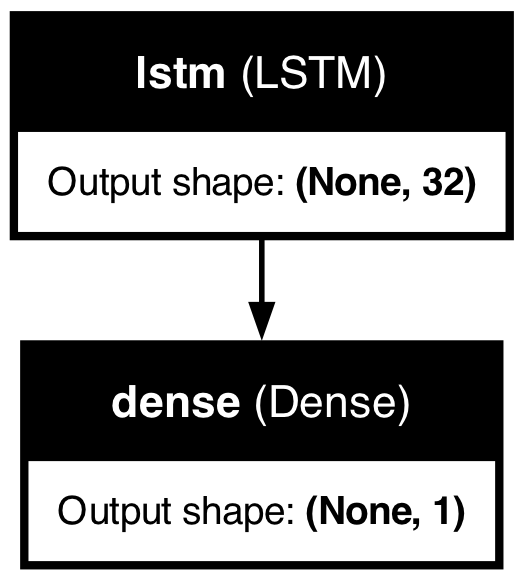

In [13]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

In [14]:
# Train the model 

history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.8458
Epoch 2/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 401.8204
Epoch 3/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 78.1277
Epoch 4/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 14.2843
Epoch 5/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1383
Epoch 6/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8666
Epoch 7/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3415
Epoch 8/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9152
Epoch 9/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4091
Epoch 10/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - loss: 1.0205
Epoch 11/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step - loss: 0.7707
Epoch 12/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6383
Epoch 13/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5899
Epoch 14/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5915
Epoch 15/100
970/970 ━━━━━━━━━━━━━━

In [15]:
# Make prediction

y_pred= lstm.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


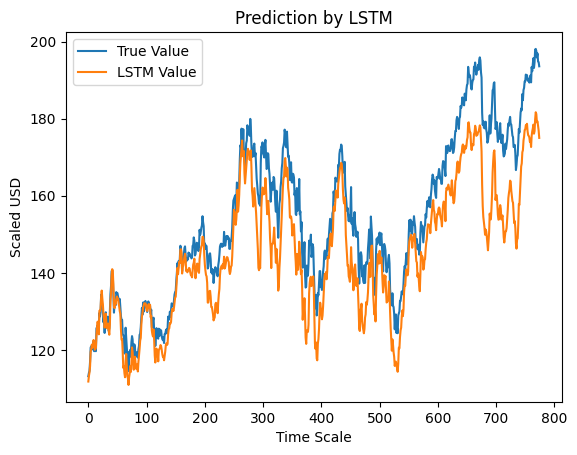

In [16]:
#Predicted vs True Adj Close Value – LSTM

plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [17]:

# Example for Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Example for Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Example for R-squared
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R-squared: {r2}")



MAE: 8.994488308814264
MSE: 116.96150525172166
R-squared: 0.7241645267701491


## Model Fine Tuning

Epoch 1/100


/Users/ryandi/anaconda3/envs/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


970/970 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.7525 - val_loss: 3121.2732
Epoch 2/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 376.5269 - val_loss: 3106.8857
Epoch 3/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 74.7048 - val_loss: 1843.7010
Epoch 4/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 11.1442 - val_loss: 1236.9764
Epoch 5/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 963us/step - loss: 0.9264 - val_loss: 1037.1027
Epoch 6/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2634 - val_loss: 982.5212
Epoch 7/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.7570 - val_loss: 954.6885
Epoch 8/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.3289 - val_loss: 929.5562
Epoch 9/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.8006 - val_loss: 903.5022
Epoch 10/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3409 - val_loss: 876.9370
Epoch 11/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9898 - val_loss: 850.3041
Epoch 12/100
970/970

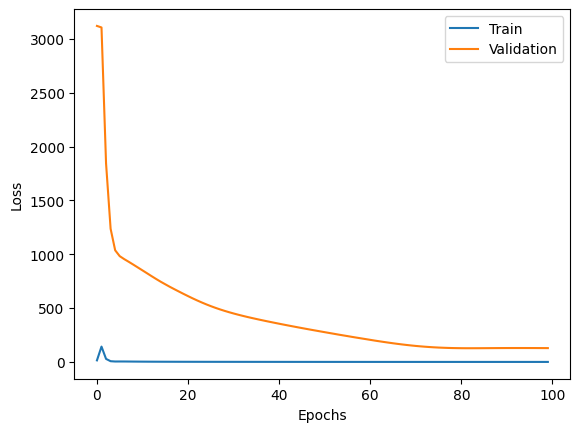

In [18]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# Function to create the LSTM model
def create_lstm_model(units=32, dropout_rate=0.0, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

# Create the LSTM model
lstm_model = create_lstm_model()

# Train the model with different hyperparameter values
history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False, validation_data=(X_test, y_test))

# Evaluate model performance
val_loss = lstm_model.evaluate(X_test, y_test)

# Print the validation loss
print(f'Validation Loss: {val_loss}')

# Visualize training and validation loss curves
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [19]:
y_pred = lstm_model.predict(X_test)

# Calculate MAE, MSE, and R-squared
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rsquared = r2_score(y_test, y_pred)

# Print the results
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {rsquared}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Mean Absolute Error (MAE): 9.407069377283896
Mean Squared Error (MSE): 128.12267053152442
R-squared: 0.6978426587322404


In [20]:
# Extract the last sequence from X_train
last_sequence = X_train[-1:]

# Reshape the last sequence to match the input shape expected by your model
last_sequence = last_sequence.reshape(1, X_train.shape[1], X_train.shape[2])

# Make the prediction
predicted_value = lstm.predict(last_sequence)

# If you used scaling during training, inverse transform the predicted value
# predicted_value = scaler.inverse_transform(predicted_value)

# Print the results
print("value for today:", df['Adj Close'].iloc[-1])
print(f"Predicted value for tomorrow: {predicted_value[0, 0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
value for today: 193.60000610351562
Predicted value for tomorrow: 113.740234375
